# OpenAi Acrobot
[Documentation](https://gymnasium.farama.org/environments/classic_control/acrobot/)  
This environment is part of the Classic Control environments which contains general information about the environment.

## Description
The Acrobot environment is based on Sutton’s work in “Generalization in Reinforcement Learning: Successful Examples Using Sparse Coarse Coding” and Sutton and Barto’s book. The system consists of two links connected linearly to form a chain, with one end of the chain fixed. The joint between the two links is actuated. The goal is to apply torques on the actuated joint to swing the free end of the linear chain above a given height while starting from the initial state of hanging downwards.

As seen in the Gif: two blue links connected by two green joints. The joint in between the two links is actuated. The goal is to swing the free end of the outer-link to reach the target height (black horizontal line above system) by applying torque on the actuator.

## imports

In [1]:
# import standard libraries
import os
import base64
import math
import random
import time
from collections import deque, namedtuple

# import third-party libraries
import gymnasium as gym
import numpy as np
import pandas as pd

import imageio
from IPython.display import clear_output
from IPython import display
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.saving import load_model
from tensorflow.keras.models import clone_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

# import additional libraries
import IPython

# display matplotlib plots inline
%matplotlib inline

## Global variables

In [2]:
MODEL = '' # 'saves/dqn_acrobot_model.h5'
SAVE_PATH = 'saves/dqn_acrobot_model.h5'

SEED = 0              # seed for pseudo-random number generator
MINIBATCH_SIZE = 64   # mini-batch size
TAU = 1e-3            # soft update parameter
E_DECAY = 0.995       # ε decay rate for ε-greedy policy
E_MIN = 0.01          # minimum ε value for ε-greedy policy
EPISODES = 25000

# Hyperparameters
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate  
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

In [3]:
# Set the random seed
random.seed(SEED)
# Set the random seed for TensorFlow
tf.random.set_seed(SEED)

## Get env informations

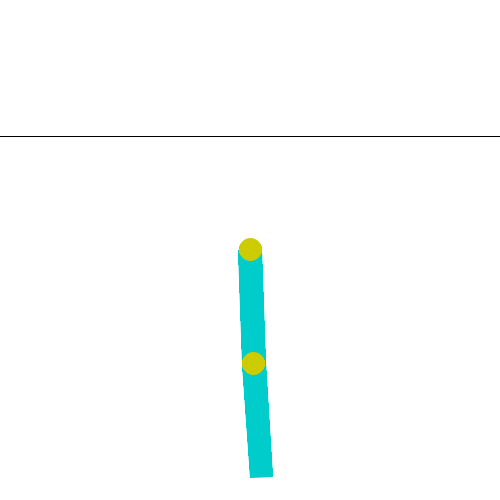

In [4]:
env = gym.make('Acrobot-v1', render_mode="rgb_array")
initial_state, _ = env.reset()
Image.fromarray(env.render())

In [5]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)
print('Reward threshold:', env.spec.reward_threshold)

State Shape: (6,)
Number of actions: 3
Reward threshold: -100.0


In [6]:
high = env.observation_space.high
low = env.observation_space.low
print(f"high:\t\t{high}")
print(f"low:\t\t{low}")
print(f"initial_state:\t{initial_state}")

high:		[ 1.        1.        1.        1.       12.566371 28.274334]
low:		[ -1.        -1.        -1.        -1.       -12.566371 -28.274334]
initial_state:	[ 0.9994535   0.03305713  0.9993654   0.03562099 -0.03767775 -0.05912155]


### Actions
|Num|Action|Unit|
|---|---|---|
|0|apply -1 torque to the actuated joint|torque (N m)|
|1|apply 0 torque to the actuated joint|torque (N m)|
|2|apply 1 torque to the actuated joint|torque (N m)|


## Set-up the Agent

In [7]:
class DQNAgent:
    """
    A DQN Agent which uses Q-learning to learn the optimal policy for a given environment.

    Attributes:
        env: gym environment object
            The environment for which the agent is being created.
        state_size: tuple
            The shape of the observation space of the environment.
        num_actions: int
            The number of possible actions in the environment.
        q_network: Keras Sequential Model object
            The Q-network which predicts the Q-value for the given state-action pair.
        target_q_network: Keras Sequential Model object
            The target Q-network which is used to compute the target Q-value for the next state.
        optimizer: Adam object
            The optimizer used to update the Q-network weights.
        replay_memory: deque object
            The replay buffer which stores the experiences for learning.
        alpha: float
            The learning rate.
        gamma: float
            The discount factor for future rewards.
    """
    def __init__(self, alpha: float = ALPHA, gamma: float = GAMMA, memory_size: int = MEMORY_SIZE, model_path: str = None):
        """
        Initializes the DQNAgent object.

        Args:
            alpha: float, optional
                The learning rate. Default is ALPHA.
            gamma: float, optional
                The discount factor for future rewards. Default is GAMMA.
            memory_size: int, optional
                The size of the replay buffer. Default is MEMORY_SIZE.
            model_path: str, optional
                The path to the saved Q-network weights. If None, a new Q-network is created.
        """
        # environment params
        self.env = gym.make("Acrobot-v1", render_mode="rgb_array")
        self.state_size = self.env.observation_space.shape
        self.num_actions = self.env.action_space.n
        
        # Create the Q-Network (main model, gets trained every step)
        self.q_network = self.create_model() if not model_path else load_model(model_path, compile=False)
        
        # Create the target Q^-Network (Target model this model will .predict against every single steps)
        self.target_q_network = self.create_model() if not model_path else load_model(model_path, compile=False)
        self.target_q_network.set_weights(self.q_network.get_weights())
        
        self.optimizer = Adam(learning_rate=alpha)
        
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        # Create a memory buffer D with capacity N
        self.replay_memory = deque(maxlen=memory_size)
        
        # hyperparameters
        self.alpha = alpha
        self.gamma = gamma
        
    def create_model(self) -> Sequential:
        """
        Creates a Q-network.

        Returns:
            Sequential:
                The Q-network.
        """
        return Sequential([
            Input(shape=self.state_size),                      
            Dense(units=64, activation='relu'),            
            Dense(units=64, activation='relu'),
            Dense(units=32, activation='relu'),
            Dense(units=self.num_actions, activation='linear'),
        ])
    
    def compute_loss(self, experiences):
        """
        Computes the loss for the Q-network.

        Args:
            experiences: tuple
                A tuple of (states, actions, rewards, next_states, done_vals).

        Returns:
            float:
                The loss for the Q-network.
        """
        # Unpack the mini-batch of experience tuples
        states, actions, rewards, next_states, done_vals = experiences

        # Compute max Q^(s,a)
        max_qsa = tf.reduce_max(self.target_q_network(next_states), axis=-1)

        # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
        y_targets = rewards + (self.gamma * max_qsa * (1 - done_vals))

        # Get the q_values
        q_values = self.q_network(states)
        q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]), tf.cast(actions, tf.int32)], axis=1))

        # Compute the loss
        loss = MSE(y_targets, q_values)

        return loss
    
    def update_target_network(self):
        """
        Update the weights of the target Q-Network with those of the Q-Network using a soft update.

        Returns:
            None
        """
        for target_weights, q_net_weights in zip(self.target_q_network.weights, self.q_network.weights):
            target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)
    
    @tf.function
    def agent_learn(self, experiences):
        """
        Update the Q-Network using the provided mini-batch of experiences.

        Args:
            experiences: a tuple containing the states, actions, rewards, next states, and done values.

        Returns:
            None
        """
        # Calculate the loss
        with tf.GradientTape() as tape:
            loss = self.compute_loss(experiences)

        trainable_variables = self.q_network.trainable_variables
        # Get the gradients of the loss with respect to the weights.
        gradients = tape.gradient(loss, trainable_variables)

        # Update the weights of the q_network.
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

        # update the weights of target q_network
        self.update_target_network()
    
    def get_action(self, q_values, epsilon=0):
        """
        Select the action to take based on the given Q-values and epsilon.

        Args:
            q_values: a tensor representing the Q-values of the current state.
            epsilon: the exploration rate.

        Returns:
            The index of the action to take.
        """
        if random.random() > epsilon:
            return np.argmax(q_values.numpy()[0])
        else:
            return random.choice(np.arange(self.num_actions))
    
    def check_update_conditions(self, t, num_steps_upd):
        """
        Check if the Q-Network should be updated.

        Args:
            t: the current time step.
            num_steps_upd: the number of time steps before updating the Q-Network.

        Returns:
            True if the Q-Network should be updated, False otherwise.
        """
        if (t + 1) % num_steps_upd == 0 and len(self.replay_memory) > MINIBATCH_SIZE:
            return True
        else:
            return False
        
    def get_experiences(self):
        """
        Get a mini-batch of experiences from the replay memory.

        Returns:
            A tuple containing the states, actions, rewards, next states, and done values.
        """
        experiences = random.sample(self.replay_memory, k=MINIBATCH_SIZE)
        states = tf.convert_to_tensor(np.array([e.state for e in experiences if e is not None]), dtype=tf.float32)
        actions = tf.convert_to_tensor(np.array([e.action for e in experiences if e is not None]), dtype=tf.float32)
        rewards = tf.convert_to_tensor(np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32)
        next_states = tf.convert_to_tensor(np.array([e.next_state for e in experiences if e is not None]), dtype=tf.float32)
        done_vals = tf.convert_to_tensor(np.array([e.done for e in experiences if e is not None]).astype(np.uint8), dtype=tf.float32)
        return (states, actions, rewards, next_states, done_vals)
    
    def get_new_eps(self, epsilon):
        """
        Return the new exploration rate after decaying it.

        Args:
            epsilon (float): the current exploration rate.

        Returns:
            float: the new exploration rate.
        """
        return max(E_MIN, E_DECAY*epsilon)

    
    def __update_plot(self, frame_number, state, num_iteration):
        """
        Updates the plot with the current state and action taken.

        Args:
            frame_number (int): the current time step.
            state (np.ndarray): the current state of the environment.
            num_iteration (int): the number of iterations left.

        Returns:
            np.ndarray: the plot of the current state.
            int: the updated time step.
            np.ndarray: the updated state of the environment.
            int: the updated number of iterations left.
        """
        current_state = np.expand_dims(state, axis=0)
        q_values = self.q_network(current_state)
        action = np.argmax(q_values.numpy()[0])
        current_state, _, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated
        frame = self.env.render()

        # converting state to plot in order to stylize it
        fig = Figure()
        canvas = FigureCanvas(fig)
        ax = fig.add_subplot(1,1,1)
        ax.imshow(frame)
        ax.axis('off')
        ax.set_title(f"Timestep=({frame_number})")
        canvas.draw()

        # reconverting plot to state
        size = fig.get_size_inches() * fig.dpi
        image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(size[1]), int(size[0]), 3)

        if done:
            current_state, _ = self.env.reset()
            num_iteration -= 1
            time.sleep(0.5)
            frame_number = 0
        else:
            frame_number += 1
        return image, frame_number, current_state, num_iteration
    
    def save(self):
        """Saves an animated GIF of the agent's performance."""
        state, _ = self.env.reset()
        frame = self.env.render()
        num_iteration = 5
        images = []
        frame_number = 0
        while num_iteration > 0:
            print(f"{(5 - num_iteration)+1}/{5}", end="\r")
            frame, frame_number, state, num_iteration = self.__update_plot(frame_number, state, num_iteration)
            images.append(Image.fromarray(frame))
        print("\nSaving..............", end="\r")            
        images[0].save('img/dqn_acrobot.gif', format='GIF', save_all=True, append_images=images[1:], duration=50, loop=0)
        print("Saved                            ")

In [8]:
def train(model_path: str = MODEL):
    """
    Trains a DQN agent to solve acrobot gym environment.

    Args:
        model_path (str): Path to the saved model weights. Defaults to MODEL.

    Returns:
        Tuple: Trained DQNAgent object and list of total points obtained during training.
    """
    start = time.time()

    num_episodes = 2000
    max_num_timesteps = 1000

    total_point_history = []

    num_p_av = 100    # number of total points to use for averaging
    epsilon = 1.0     # initial ε value for ε-greedy policy

    # Create DQNAgent
    agent = DQNAgent(model_path=model_path)
    agent.q_network.summary()

    for i in range(num_episodes):
        # Reset the environment to the initial state and get the initial state
        state, _ = agent.env.reset()
        total_points = 0

        for t in range(max_num_timesteps):

            # From the current state S choose an action A using an ε-greedy policy
            state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
            q_values = agent.q_network(state_qn)
            action = agent.get_action(q_values, epsilon)

            # Take action A and receive reward R and the next state S'
            next_state, reward, terminated, truncated, _ = agent.env.step(action)
            done = terminated or truncated

            # Store experience tuple (S,A,R,S') in the memory buffer.
            # We store the done variable as well for convenience.
            experience = agent.experience(state, action, reward, next_state, done)
            agent.replay_memory.append(experience)

            # Update total reward and current state
            state = next_state.copy()
            total_points += reward

            # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
            if agent.check_update_conditions(t, NUM_STEPS_FOR_UPDATE):
                # Sample random mini-batch of experience tuples (S,A,R,S') from D
                experiences = agent.get_experiences()
                # Set the y targets, perform a gradient descent step,
                # and update the network weights.
                agent.agent_learn(experiences)

            if done:
                break

        total_point_history.append(total_points)
        av_latest_points = np.mean(total_point_history[-num_p_av:])

        # Update the ε value
        epsilon = agent.get_new_eps(epsilon)

        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

        if (i+1) % num_p_av == 0:
            print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

        # We will consider that the environment is solved if we get an
        # average of 200 points in the last 100 episodes.
        if av_latest_points >= agent.env.spec.reward_threshold:
            print(f"\n\nEnvironment solved in {i+1} episodes!")
            agent.q_network.save(SAVE_PATH)
            break

    tot_time = time.time() - start

    print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")
    return agent, total_point_history

In [9]:
def plot_history(reward_history, rolling_window=20, lower_limit=None, upper_limit=None, plot_rw=True, plot_rm=True):
    """
    Function to plot reward history and its rolling mean with some optional arguments.

    Args:
        reward_history (list): A list of rewards for each episode.
        rolling_window (int): The number of episodes for computing the rolling mean.
        lower_limit (int): Starting episode index for plotting.
        upper_limit (int): Ending episode index for plotting.
        plot_rw (bool): A flag for plotting raw reward history.
        plot_rm (bool): A flag for plotting rolling mean reward history.

    Returns:
        None
    """
    
    # If lower_limit and upper_limit are not provided, use the whole reward_history
    if lower_limit is None or upper_limit is None:
        rh = reward_history
        xs = [x for x in range(len(reward_history))]
    else:
        rh = reward_history[lower_limit:upper_limit]
        xs = [x for x in range(lower_limit,upper_limit)]
   
    # Create a DataFrame and calculate the rolling mean
    df = pd.DataFrame(rh)
    rollingMean = df.rolling(rolling_window).mean()

    # Plot the results
    plt.figure(figsize=(10,7), facecolor='white')
    
    if plot_rw:
        plt.plot(xs, rh, linewidth=1, color='cyan')
    if plot_rm:
        plt.plot(xs, rollingMean, linewidth=2, color='magenta')

    text_color = 'black'
        
    ax = plt.gca()
    ax.set_facecolor('black')
    plt.grid()

    plt.xlabel('Episode', color=text_color, fontsize=30)
    plt.ylabel('Total Points', color=text_color, fontsize=30)
    yNumFmt = mticker.StrMethodFormatter('{x:,}')
    ax.yaxis.set_major_formatter(yNumFmt)
    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)
    plt.show()

## First pass

In [10]:
agent, total_point_history = train()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                448       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 6,787
Trainable params: 6,787
Non-trainable params: 0
_________________________________________________________________
Episode 100 | Total point average of the last 100 episodes: -463.88
Episode 200 | Total point average of the last 100 episodes: -274.62
Episode 300 | Total point average of the last 100 

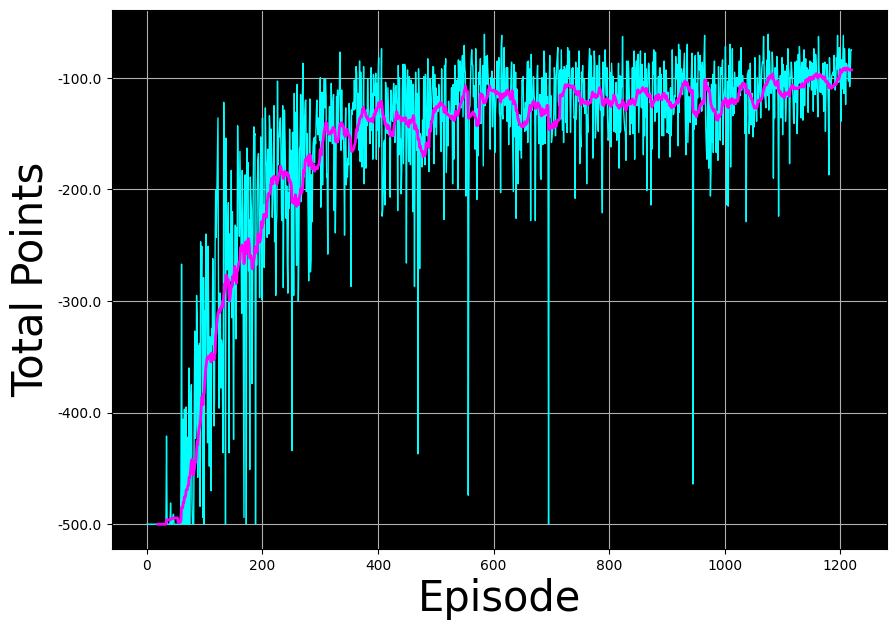

In [11]:
# Plot the point history
plot_history(total_point_history)

## Second Pass

In [12]:
agent, total_point_history = train(SAVE_PATH)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                448       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 6,787
Trainable params: 6,787
Non-trainable params: 0
_________________________________________________________________
Episode 100 | Total point average of the last 100 episodes: -345.11
Episode 200 | Total point average of the last 100 episodes: -161.96
Episode 300 | Total point average of the last 100 

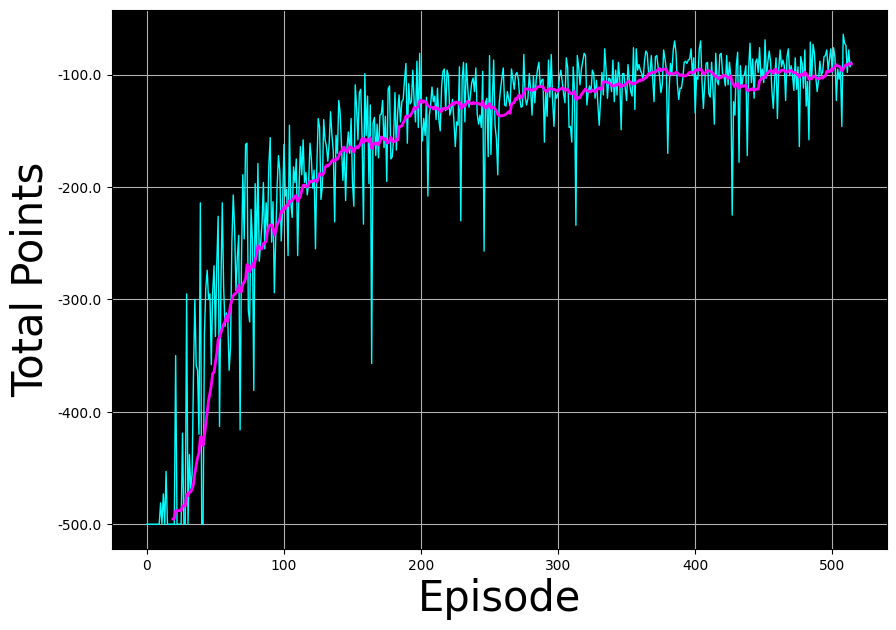

In [13]:
# Plot the point history
plot_history(total_point_history)

## Generate a gif

In [14]:
def embed_gif(filename):
    """Embeds an mp4 file in the notebook."""
    gif = open(filename,'rb').read()
    b64 = base64.b64encode(gif)
    tag = '''<img width="840" height="480"  src="data:img/gif;base64,{0}"/>'''.format(b64.decode())
    return IPython.display.HTML(tag)

In [15]:
dqn_agent = DQNAgent(model_path=SAVE_PATH)

In [16]:
dqn_agent.save()

5/5
Saved                            


In [17]:
filename = "./img/dqn_acrobot.gif"
embed_gif(filename)